# <center> <span style="color:orange"> Cryptos </span> </center>

# ----------------------------------------- 2018 -----------------------------------------

In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (12, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [249]:
#année 2018
S = pd.read_csv('YahooF_Datas/cryptos/année_2018_DF.csv', index_col = 0, parse_dates = True)

In [250]:
from universal.algos import *


R = S / S.shift(1)
highest_return_symbol = R.idxmax(axis=1).shift(1)
lower_return_symbol = R.idxmin(axis=1).shift(1)


W_mom = S * 0
for col in R.columns:
    W_mom.loc[highest_return_symbol == col, col] = 1

W_rev = S * 0
for col in R.columns:
    W_rev.loc[lower_return_symbol == col, col] = 1

In [251]:
plot_kwargs = {
    "logy": True,
    "assets": False,
    "weights": False,
    "ucrp": True,
}
#mesure de performance algo
def perform(result):
    print('Le ratio de Sharpe est : ' , result.sharpe)
    print('Le Beta est : ', result.alpha_beta()[1])

In [252]:
algo = CRP(W_mom)
result1 = algo.run(S)
r_mom = result1.r_log

In [253]:
algo = CRP(W_rev)
result2 = algo.run(S)
r_rev = result2.r_log

<AxesSubplot:xlabel='Date'>

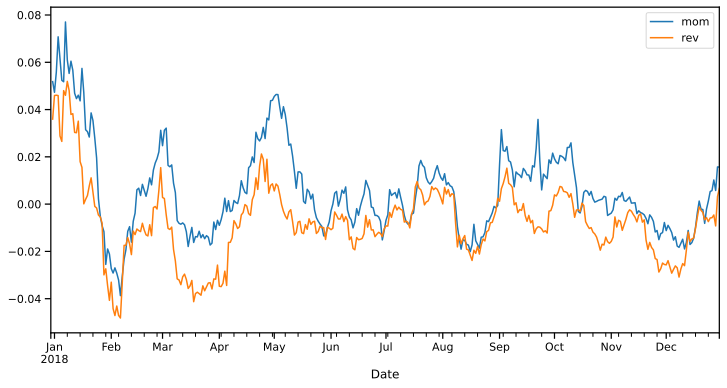

In [254]:
# get recent performance, e.g. last 22 days
PERIOD = 22
performance = pd.DataFrame({
    'mom': r_mom.rolling(PERIOD).mean(),
    'rev': r_rev.rolling(PERIOD).mean(),
})

# shift performance by 1 day to avoid lookahead bias
performance = performance['2017-12-30':'2018-12-30']
performance = performance.shift(1)

# plot performance
performance.plot()

<AxesSubplot:xlabel='Date'>

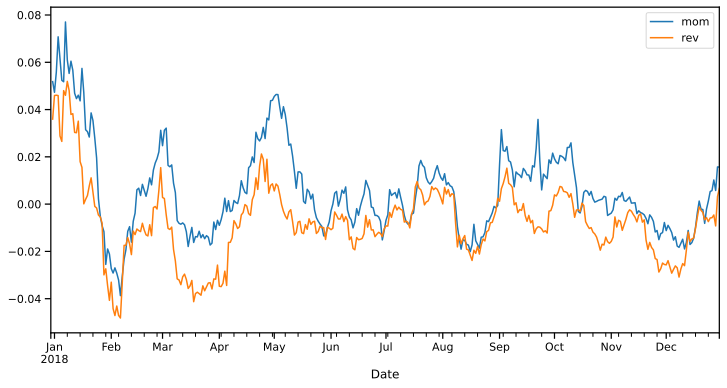

In [255]:
performance.plot()

<AxesSubplot:>

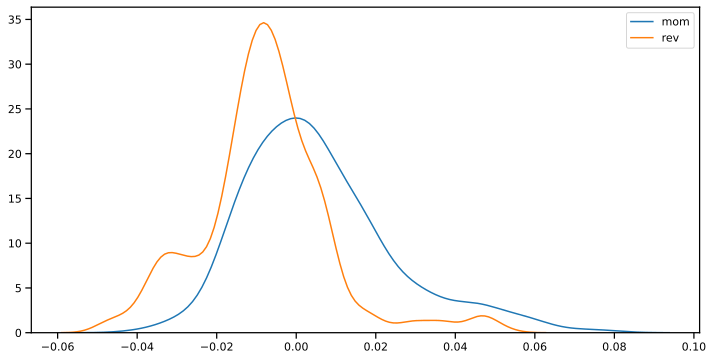

In [256]:
sns.kdeplot(performance['mom'])
sns.kdeplot(performance['rev'])

In [257]:
performance['difference'] = performance.mom - performance.rev

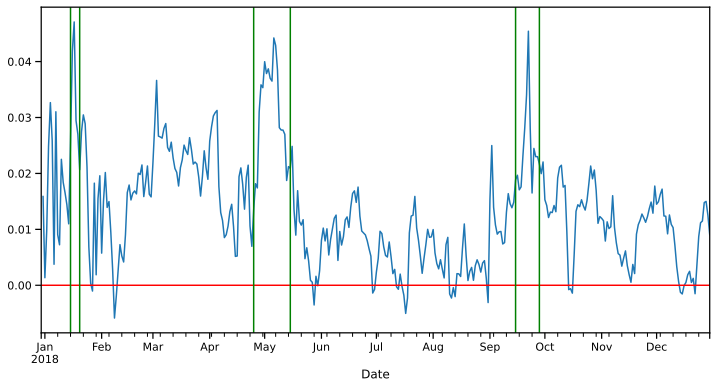

In [258]:
performance['difference'].plot()
plt.axhline(y = 0, color = 'red')
plt.axvline(x = '2018-04-25' , color = 'green')
plt.axvline(x = '2018-05-15' , color = 'green')
plt.axvline(x = '2018-09-15' , color = 'green')
plt.axvline(x = '2018-09-28' , color = 'green')
plt.axvline(x = '2018-01-15' , color = 'green')
plt.axvline(x = '2018-01-20' , color = 'green')

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2956/4106761579.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  performance['2018-01'].plot(ax = ax1)
/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2956/4106761579.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  performance['2018-09'].plot(ax = ax2)


<AxesSubplot:xlabel='Date'>

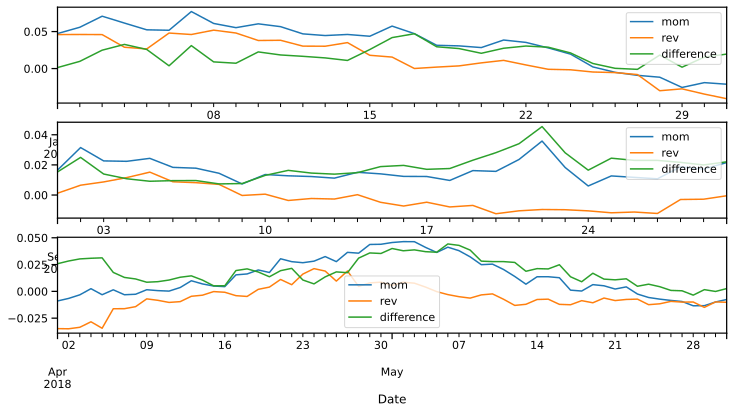

In [259]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
performance['2018-01'].plot(ax = ax1)
performance['2018-09'].plot(ax = ax2)
performance['2018-04':'2018-05'].plot(ax = ax3)

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2956/1132364090.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  S['2018-01'].plot(ax = ax1)
/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2956/1132364090.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  S['2018-09'].plot(ax = ax2, legend = False)


<AxesSubplot:xlabel='Date'>

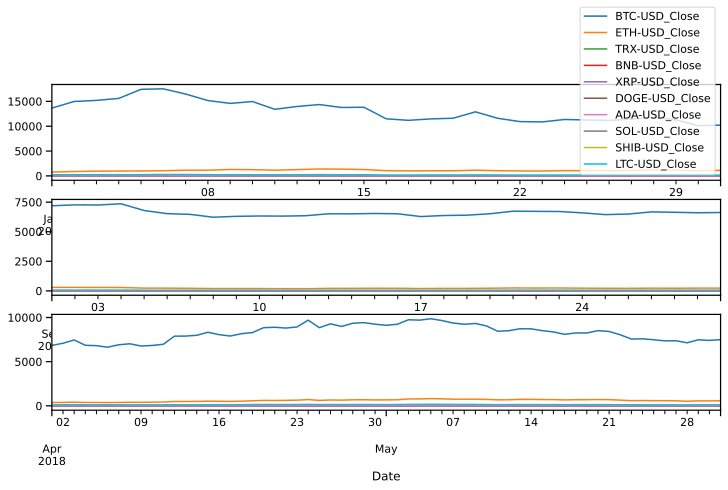

In [263]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
S['2018-01'].plot(ax = ax1)
S['2018-09'].plot(ax = ax2, legend = False)
S['2018-04':'2018-05'].plot(ax = ax3, legend = False)

In [193]:
print('pour reversion strategy : ',perform(result2))
print('pour momentum strategy : ' , perform(result1))

Le ratio de Sharpe est :  0.9505390340846743
Le Beta est :  1.1838654823911168
pour reversion strategy :  None
Le ratio de Sharpe est :  1.2766942504044971
Le Beta est :  1.356599577931513
pour momentum strategy :  None


In [194]:
# construct new weight matrix from momentum and reversal
mom_better = (performance.mom > performance.rev)
rev_better = (performance.rev > performance.mom)
W = W_mom.mul(mom_better, axis=0) + W_rev.mul(rev_better, axis=0)

print(f'Momentum is better {mom_better.mean():.2%} of time')
print(f'Reversal is better {rev_better.mean():.2%} of time')

# fill the rest with uniform weights so that it's comparable to UCRP
W.iloc[:PERIOD, :] = 1./100

Momentum is better 92.90% of time
Reversal is better 6.83% of time


Le ratio de Sharpe est :  0.44616959436571985
Le Beta est :  0.18094082996853605
None


(17532.0, 17897.0)

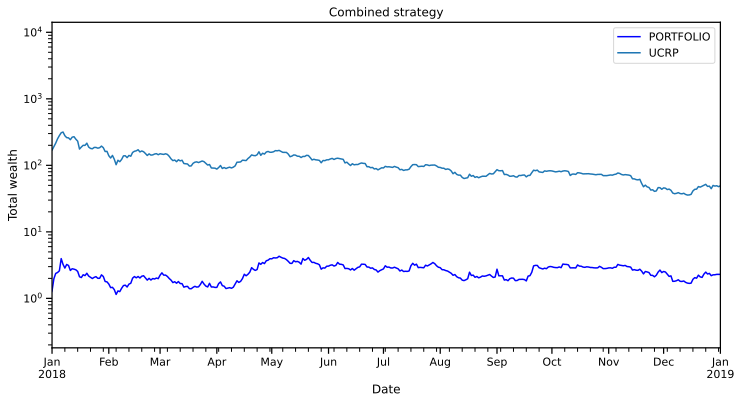

In [195]:
# final combined strategy
algo = CRP(W)
result = algo.run(S)
print(perform(result))
result.plot(logy=True, assets=False, weights=False, ucrp=True, title='Combined strategy')
plt.xlim(['2018','2019'])

In [196]:
#ajout colonne : 1 si momentum marche , 0 si reversion
performance['choix'] = performance['difference'].apply(lambda x : 1 if x > 0 else 0)

In [197]:
mome = [1]
reve = [0]

In [198]:
sharp_r = [result2.sharpe]
beta_r = [result2.alpha_beta()[1]]
sharp_m = [result1.sharpe]
beta_m = [result1.alpha_beta()[1]]

# ----------------------------------------- 2019 -----------------------------------------

In [199]:
#année 2019
S = pd.read_csv('YahooF_Datas/cryptos/année_2019_DF.csv', index_col = 0, parse_dates = True)

In [200]:
R = S / S.shift(1)
highest_return_symbol = R.idxmax(axis=1).shift(1)
lower_return_symbol = R.idxmin(axis=1).shift(1)


W_mom = S * 0
for col in R.columns:
    W_mom.loc[highest_return_symbol == col, col] = 1

W_rev = S * 0
for col in R.columns:
    W_rev.loc[lower_return_symbol == col, col] = 1

algo = CRP(W_mom)
result1 = algo.run(S)
r_mom = result1.r_log

algo = CRP(W_rev)
result2 = algo.run(S)
r_rev = result2.r_log

<AxesSubplot:xlabel='Date'>

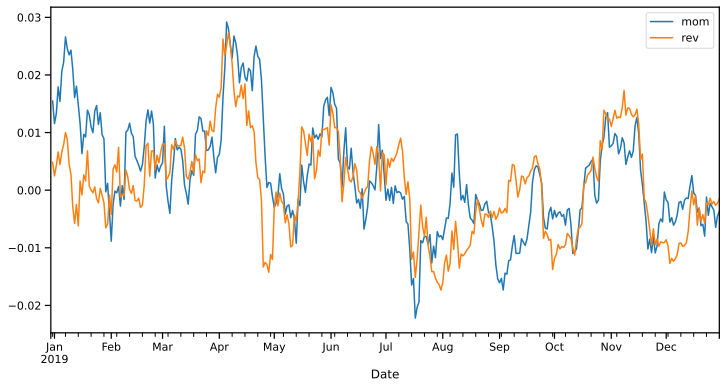

In [201]:
# get recent performance, e.g. last 22 days
PERIOD = 22
performance1 = pd.DataFrame({
    'mom': r_mom.rolling(PERIOD).mean(),
    'rev': r_rev.rolling(PERIOD).mean(),
})

# shift performance by 1 day to avoid lookahead bias
performance1 = performance1['2018-12-30':'2019-12-30']
performance1 = performance1.shift(1)

# plot performance
performance1.plot()

<AxesSubplot:>

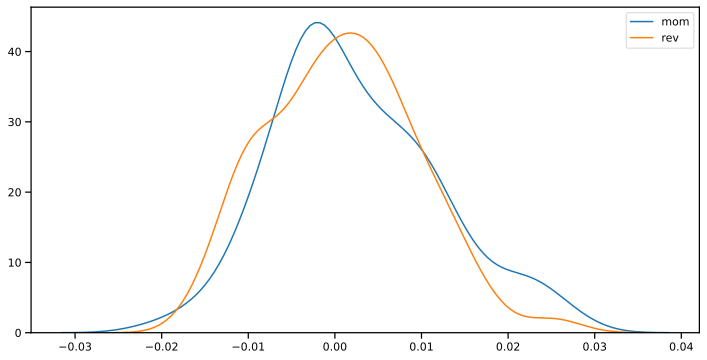

In [202]:
sns.kdeplot(performance1['mom'])
sns.kdeplot(performance1['rev'])

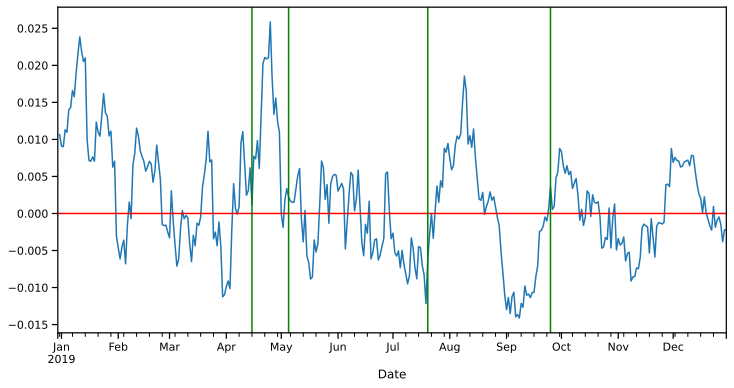

In [203]:
performance1['difference'] = performance1.mom - performance1.rev

performance1['difference'].plot()
plt.axhline(y = 0, color = 'red')
plt.axvline(x = '2019-04-15' , color = 'green')
plt.axvline(x = '2019-05-05' , color = 'green')
plt.axvline(x = '2019-07-20' , color = 'green')
plt.axvline(x = '2019-09-25' , color = 'green')

<AxesSubplot:xlabel='Date'>

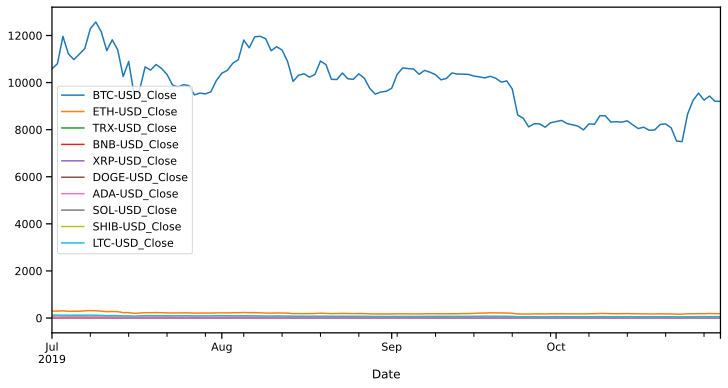

In [204]:
S['2019-07':'2019-10'].plot()
#plt.ylim([-100,400])

In [205]:
print('pour reversion strategy : ',perform(result2))
print('pour momentum strategy : ' , perform(result1))

Le ratio de Sharpe est :  0.9505390340846743
Le Beta est :  1.1838654823911168
pour reversion strategy :  None
Le ratio de Sharpe est :  1.2766942504044971
Le Beta est :  1.356599577931513
pour momentum strategy :  None


In [206]:
# construct new weight matrix from momentum and reversal
mom_better = (performance1.mom > performance1.rev)
rev_better = (performance1.rev > performance1.mom)
W = W_mom.mul(mom_better, axis=0) + W_rev.mul(rev_better, axis=0)

print(f'Momentum is better {mom_better.mean():.2%} of time')
print(f'Reversal is better {rev_better.mean():.2%} of time')

# fill the rest with uniform weights so that it's comparable to UCRP
W.iloc[:PERIOD, :] = 1./100

Momentum is better 54.10% of time
Reversal is better 45.63% of time


Le ratio de Sharpe est :  0.03780787482974305
Le Beta est :  0.06873985654697676
None


(17897.0, 18262.0)

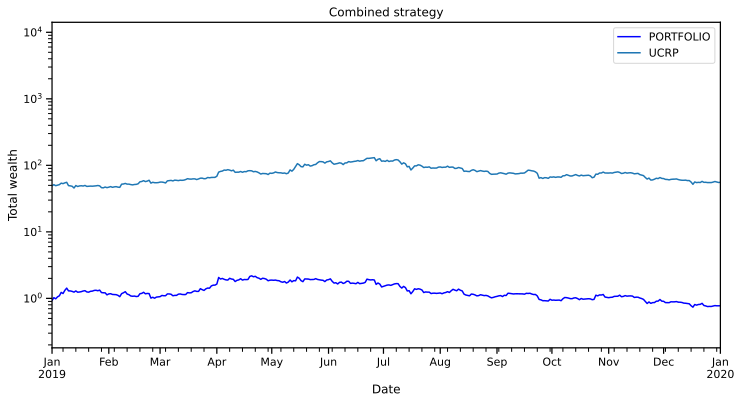

In [207]:
# final combined strategy
algo = CRP(W)
result = algo.run(S)
print(perform(result))
result.plot(logy=True, assets=False, weights=False, ucrp=True, title='Combined strategy')
plt.xlim(['2019','2020'])

In [208]:
#ajout colonne : 1 si momentum marche , 0 si reversion
performance1['choix'] = performance1['difference'].apply(lambda x : 1 if x > 0 else 0)

In [209]:
mome.append(1)
reve.append(0)

In [212]:
sharp_r.append(result2.sharpe)
beta_r.append(result2.alpha_beta()[1])
sharp_m.append(result1.sharpe)
beta_m.append(result1.alpha_beta()[1])

# ---------------------------------------- Covid ----------------------------------------

In [264]:
#covid 
S = pd.read_csv('YahooF_Datas/cryptos/covid_DF.csv', index_col = 0, parse_dates = True)

In [265]:
R = S / S.shift(1)
highest_return_symbol = R.idxmax(axis=1).shift(1)
lower_return_symbol = R.idxmin(axis=1).shift(1)


W_mom = S * 0
for col in R.columns:
    W_mom.loc[highest_return_symbol == col, col] = 1

W_rev = S * 0
for col in R.columns:
    W_rev.loc[lower_return_symbol == col, col] = 1

algo = CRP(W_mom)
result1 = algo.run(S)
r_mom = result1.r_log

algo = CRP(W_rev)
result2 = algo.run(S)
r_rev = result2.r_log

<AxesSubplot:xlabel='Date'>

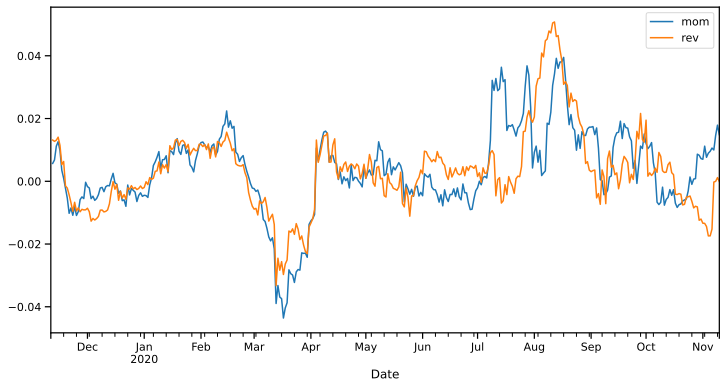

In [266]:
# get recent performance, e.g. last 22 days
PERIOD = 22
performance2 = pd.DataFrame({
    'mom': r_mom.rolling(PERIOD).mean(),
    'rev': r_rev.rolling(PERIOD).mean(),
})

# shift performance by 1 day to avoid lookahead bias
performance2 = performance2['2019-11-11':'2020-11-10']
performance2 = performance2.shift(1)

# plot performance
performance2.plot()

<AxesSubplot:>

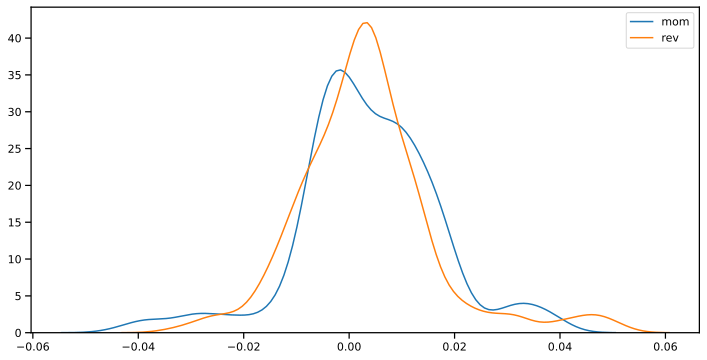

In [267]:
sns.kdeplot(performance2['mom'])
sns.kdeplot(performance2['rev'])

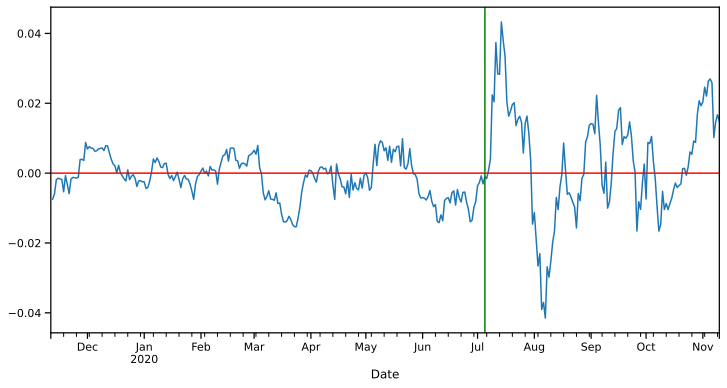

In [268]:
performance2['difference'] = performance2.mom - performance2.rev

performance2['difference'].plot()
plt.axhline(y = 0, color = 'red')
plt.axvline(x = '2020-07-05', color = 'green')

/var/folders/12/84yzr4v96cs825ywcskr493c0000gn/T/ipykernel_2956/2322820241.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  S['2020-07'].plot()


<AxesSubplot:xlabel='Date'>

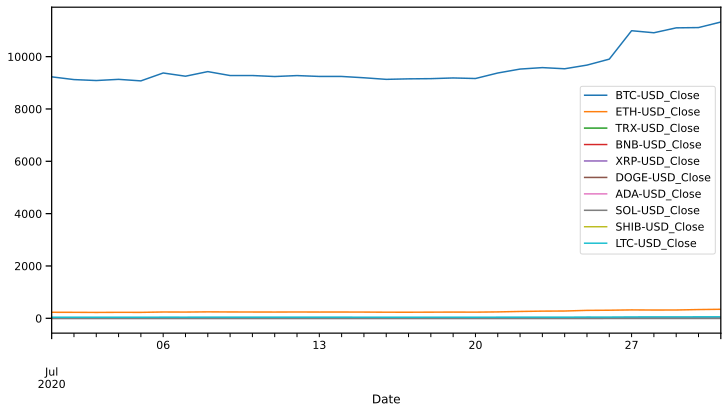

In [270]:
S['2020-07'].plot()

In [218]:
print('pour reversion strategy : ',perform(result2))
print('pour momentum strategy : ' , perform(result1))

Le ratio de Sharpe est :  0.950619432093177
Le Beta est :  1.1838663884223017
pour reversion strategy :  None
Le ratio de Sharpe est :  1.276730318591951
Le Beta est :  1.3565975474759422
pour momentum strategy :  None


In [219]:
# construct new weight matrix from momentum and reversal
mom_better = (performance2.mom > performance2.rev)
rev_better = (performance2.rev > performance2.mom)
W = W_mom.mul(mom_better, axis=0) + W_rev.mul(rev_better, axis=0)

print(f'Momentum is better {mom_better.mean():.2%} of time')
print(f'Reversal is better {rev_better.mean():.2%} of time')

# fill the rest with uniform weights so that it's comparable to UCRP
W.iloc[:PERIOD, :] = 1./100

Momentum is better 46.99% of time
Reversal is better 52.73% of time


Le ratio de Sharpe est :  0.46852202767530277
Le Beta est :  0.09818198900061541
None


(18201.0, 18567.0)

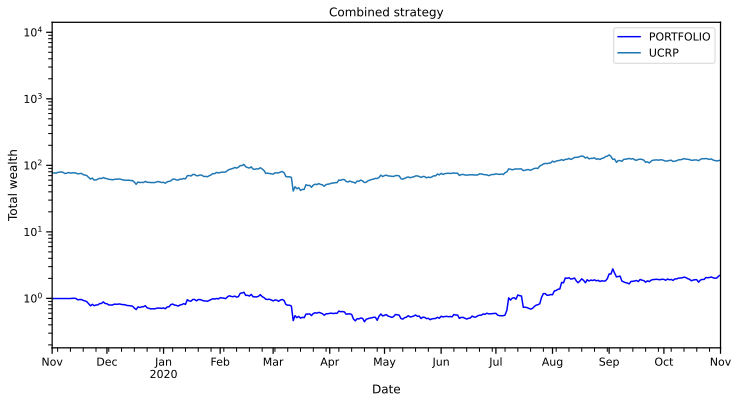

In [220]:
# final combined strategy
algo = CRP(W)
result = algo.run(S)
print(perform(result))
result.plot(logy=True, assets=False, weights=False, ucrp=True, title='Combined strategy')
plt.xlim(['2019-11','2020-11'])

In [221]:
#ajout colonne : 1 si momentum marche , 0 si reversion
performance2['choix'] = performance2['difference'].apply(lambda x : 1 if x > 0 else 0)

In [222]:
mome.append(0)
reve.append(1)

In [223]:
sharp_r.append(result2.sharpe)
beta_r.append(result2.alpha_beta()[1])
sharp_m.append(result1.sharpe)
beta_m.append(result1.alpha_beta()[1])

# ----------------------------------- Guerre ukraine -----------------------------------

In [271]:
#guerre ukraine
S = pd.read_csv('YahooF_Datas/cryptos/ukr_war_DF.csv', index_col = 0, parse_dates = True)

In [272]:
R = S / S.shift(1)
highest_return_symbol = R.idxmax(axis=1).shift(1)
lower_return_symbol = R.idxmin(axis=1).shift(1)


W_mom = S * 0
for col in R.columns:
    W_mom.loc[highest_return_symbol == col, col] = 1

W_rev = S * 0
for col in R.columns:
    W_rev.loc[lower_return_symbol == col, col] = 1

algo = CRP(W_mom)
result1 = algo.run(S)
r_mom = result1.r_log

algo = CRP(W_rev)
result2 = algo.run(S)
r_rev = result2.r_log

<AxesSubplot:xlabel='Date'>

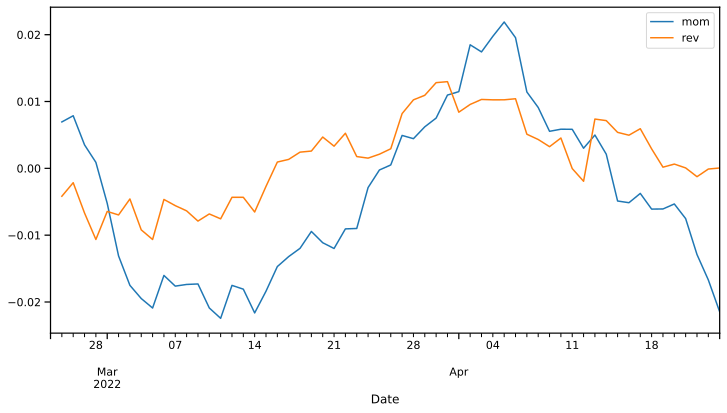

In [273]:
# get recent performance, e.g. last 22 days
PERIOD = 22
performance3 = pd.DataFrame({
    'mom': r_mom.rolling(PERIOD).mean(),
    'rev': r_rev.rolling(PERIOD).mean(),
})

# shift performance by 1 day to avoid lookahead bias
performance3 = performance3['2022-02-24':'2022-04-24']
performance3 = performance3.shift(1)

# plot performance
performance3.plot()

<AxesSubplot:>

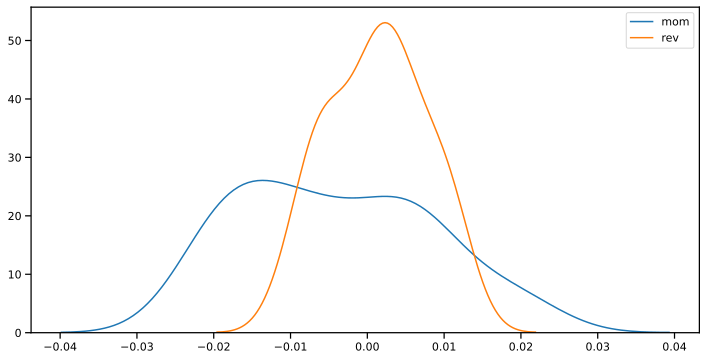

In [274]:
sns.kdeplot(performance3['mom'])
sns.kdeplot(performance3['rev'])

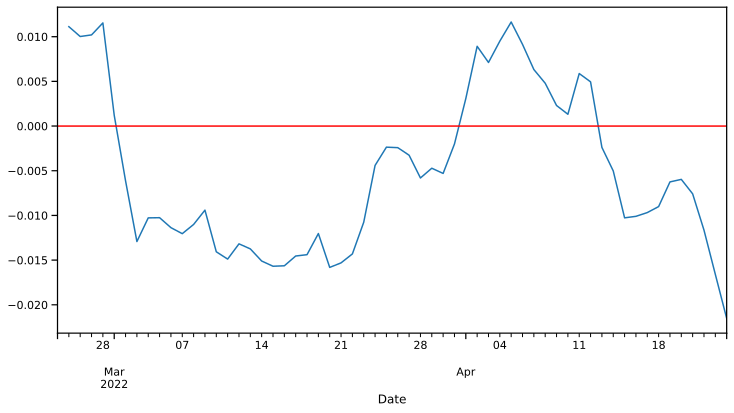

In [275]:
performance3['difference'] = performance3.mom - performance3.rev

performance3['difference'].plot()
plt.axhline(y = 0, color = 'red')

<AxesSubplot:xlabel='Date'>

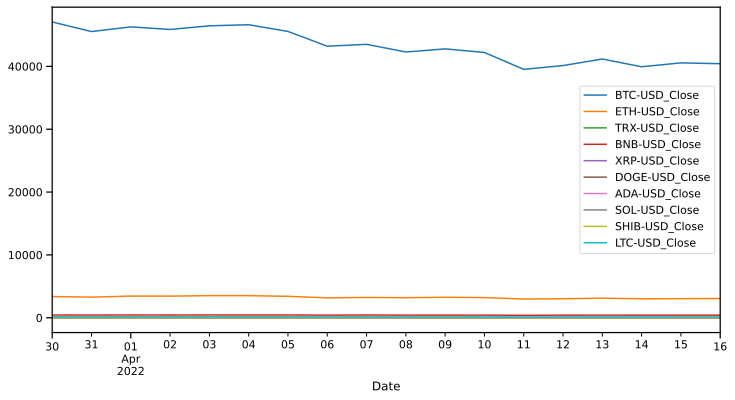

In [276]:
S['2022-03-30':'2022-04-16'].plot()

In [229]:
print('pour reversion strategy : ',perform(result2))
print('pour momentum strategy : ' , perform(result1))

Le ratio de Sharpe est :  0.9505390340846743
Le Beta est :  1.1838654888886597
pour reversion strategy :  None
Le ratio de Sharpe est :  1.2766942504044971
Le Beta est :  1.3565992792087156
pour momentum strategy :  None


In [230]:
# construct new weight matrix from momentum and reversal
mom_better = (performance3.mom > performance3.rev)
rev_better = (performance3.rev > performance3.mom)
W = W_mom.mul(mom_better, axis=0) + W_rev.mul(rev_better, axis=0)

print(f'Momentum is better {mom_better.mean():.2%} of time')
print(f'Reversal is better {rev_better.mean():.2%} of time')

# fill the rest with uniform weights so that it's comparable to UCRP
W.iloc[:PERIOD, :] = 1./100

Momentum is better 28.33% of time
Reversal is better 70.00% of time


Le ratio de Sharpe est :  -0.04583979012192946
Le Beta est :  0.011615250049744723
None


(18201.0, 18567.0)

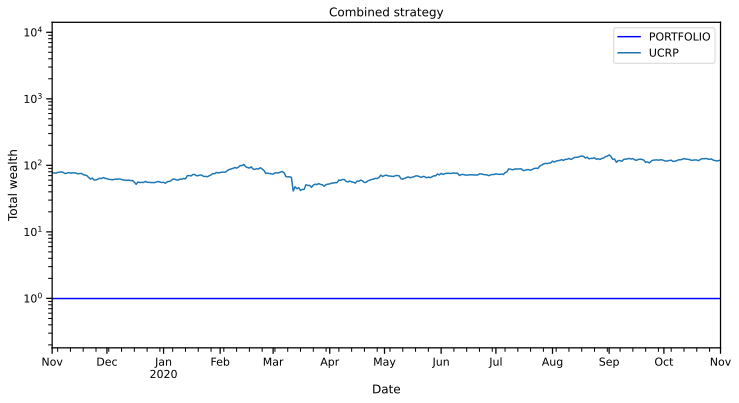

In [231]:
# final combined strategy
algo = CRP(W)
result = algo.run(S)
print(perform(result))
result.plot(logy=True, assets=False, weights=False, ucrp=True, title='Combined strategy')
plt.xlim(['2019-11','2020-11'])

In [232]:
#ajout colonne : 1 si momentum marche , 0 si reversion
performance3['choix'] = performance3['difference'].apply(lambda x : 1 if x > 0 else 0)

In [233]:
mome.append(0)
reve.append(1)

In [234]:
sharp_r.append(result2.sharpe)
beta_r.append(result2.alpha_beta()[1])
sharp_m.append(result1.sharpe)
beta_m.append(result1.alpha_beta()[1])

In [236]:
summary_table = pd.DataFrame(list(zip(mome,reve,sharp_r,beta_r,sharp_m,sharp_m)), 
                     columns = ['momentum', 'mean reversion','Sharp mean reversion','Beta mean reversion', 'Sharp momentum','beta momentum'], 
                     index = ['Année 2018', 'Année 2019', 'Covid19', 'Guerre Ukrainienne'])

In [237]:
summary_table

,momentum,mean reversion,Sharp mean reversion,Beta mean reversion,Sharp momentum,beta momentum
Année 2018,1,0,0.950539,1.183865,1.276694,1.276694
Année 2019,1,0,0.950539,1.183865,1.276694,1.276694
Covid19,0,1,0.950619,1.183866,1.276730,1.276730
Guerre Ukrainienne,0,1,0.950539,1.183865,1.276694,1.276694
